In [1]:
from settings import Settings
import matplotlib.pyplot as plt

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from utils.datasets import TrainDataset, TestDataset
from torchvision.transforms import *
from torch.autograd import Variable
from model import Net

In [2]:
settings = Settings()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [3]:
def load_dataset(dataset='train'):
    if settings.num_channels == 1:
        is_gray = True
    else:
        is_gray = False

    if dataset == 'train':
        print('Loading train datasets...')
        train_set = TrainDataset(settings=settings)
        return DataLoader(dataset=train_set, num_workers=settings.num_threads, batch_size=settings.batch_size,
                          shuffle=True)
    elif dataset == 'test':
        print('Loading test datasets...')
        test_set = TestDataset(settings=settings)
        return DataLoader(dataset=test_set, num_workers=settings.num_threads, batch_size=settings.test_batch_size,
                          shuffle=False)

In [4]:
def save_checkpoint(model, epoch):
    model_out_path = "checkpoint/" + "model_epoch_{}.pth".format(epoch)
    state = {"epoch": epoch ,"model": model}
    if not os.path.exists("checkpoint/"):
        os.makedirs("checkpoint/")

    torch.save(state, model_out_path)

    print("Checkpoint saved to {}".format(model_out_path))

In [5]:
lr = 0.1

def train(training_data_loader, optimizer, model, criterion, epoch):
    if (epoch+1) % 20 == 0:
        lr/=10.0

    print("Epoch = {}, lr = {}".format(epoch, lr))

    for iteration, batch in enumerate(training_data_loader, 1):
        input, target = Variable(batch[0]), Variable(batch[1], requires_grad=False)

        input = input.to(device)
        target = target.to(device)

        loss = criterion(model(input), target)
        optimizer.zero_grad()
        loss.backward() 
        nn.utils.clip_grad_norm(model.parameters(), settings.clip) 
        optimizer.step()

        if iteration%100 == 0:
            print("===> Epoch[{}]({}/{}): Loss: {:.10f}".format(epoch, iteration, len(training_data_loader), loss.data[0]))

In [6]:
data = load_dataset('train')
test_data = data.dataset.__getitem__(0)

Loading train datasets...
Successfully loaded.
/Users/fylsunghwan/Documents/Workspace/GitHub/VDSR-pytorch/datasets/291


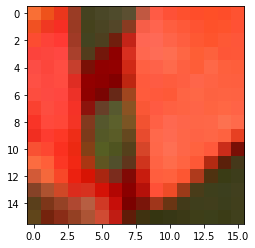

In [7]:
test_data = data.dataset.__getitem__(4)
plt.imshow(test_data[0].numpy().transpose((2, 1, 0)))

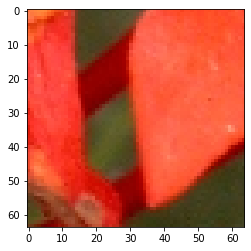

In [8]:
plt.imshow(test_data[1].numpy().transpose((2, 1, 0)))

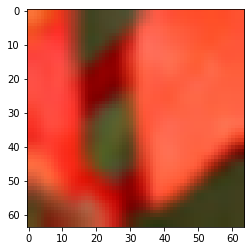

In [9]:
plt.imshow(test_data[2].numpy().transpose((2, 1, 0)))

In [16]:
for iter, batch in enumerate(data, 1):
    input, target = Variable(batch[0]), Variable(batch[1], requires_grad=False)
    print(type(input))
    

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
